<a href="https://colab.research.google.com/github/raciard/mldl_project/blob/main/Copy_of_Enhancing_6DPose_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Enhancing 6D Object Pose Estimation**

**TA:** Stephany Ortuno Chanelo (stephany.ortuno@polito.it),
Paolo Rabino (paolo.rabino@polito.it)

**TASK OVERVIEW**
This project aims to explore and implement advanced techniques for 6D pose estimation using RGB-D images. The goal is to build an end-to-end pipeline for estimating the 6D pose of objects by initially replicating a model that uses just RGB images. The pipeline will then be enhanced by incorporating depth information to improve accuracy in the pose predictions. You will adapt and implement the methodology, starting from pose prediction and then extend the model with your own innovative improvements.


#**1. DATA EXPLORATION**

During this project we will work with the LineMOD dataset. This is a widely used instance-level 6D object pose estimation dataset consisting of 13 different objects with significant shape variation.

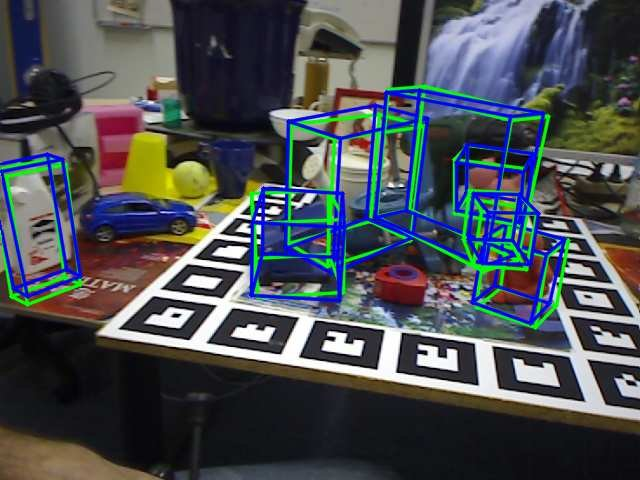

Specifically, we will work with a portion of this dataset, which you can find here: https://drive.google.com/drive/folders/19ivHpaKm9dOrr12fzC8IDFczWRPFxho7

In [ ]:
# Step 1: Download the dataset (LineMOD)
# Download LineMOD dataset
!mkdir -p datasets/linemod/
%cd datasets/linemod/


/content/datasets/linemod


In [ ]:
# Download DenseFusion Folder (Which includes a portion of the LimeMOD dataset)

!gdown --folder "https://drive.google.com/drive/folders/19ivHpaKm9dOrr12fzC8IDFczWRPFxho7"
%cd DenseFusion/
!gdown --fuzzy https://drive.google.com/file/d/137w_hJznAKgB7LKlTQEsBbfu_JbzBWHk/view?usp=drive_link
!unzip Linemod_preprocessed.zip


Streaming output truncated to the last 5000 lines.
  inflating: Linemod_preprocessed/segnet_results/11_label/0206_label.png  
  inflating: Linemod_preprocessed/segnet_results/11_label/0207_label.png  
  inflating: Linemod_preprocessed/segnet_results/11_label/0208_label.png  
  inflating: Linemod_preprocessed/segnet_results/11_label/0209_label.png  
  inflating: Linemod_preprocessed/segnet_results/11_label/0210_label.png  
  inflating: Linemod_preprocessed/segnet_results/11_label/0211_label.png  
  inflating: Linemod_preprocessed/segnet_results/11_label/0212_label.png  
  inflating: Linemod_preprocessed/segnet_results/11_label/0213_label.png  
  inflating: Linemod_preprocessed/segnet_results/11_label/0214_label.png  
  inflating: Linemod_preprocessed/segnet_results/11_label/0215_label.png  
  inflating: Linemod_preprocessed/segnet_results/11_label/0216_label.png  
  inflating: Linemod_preprocessed/segnet_results/11_label/0218_label.png  
  inflating: Linemod_preprocessed/segnet_results/

**NOTE:** If you need to install some specific libraries you can do it by using the following command

In [ ]:
#!pip3 install open3d
! pip install pcl

  Preparing metadata (setup.py) ... done
  Created wheel for pcl: filename=pcl-0.0.0.post1-py3-none-any.whl size=1690 sha256=2a55d39616ca70296e17895a8eb888f20de204e4ccbda6276e2e65a07f79b0ac
  Stored in directory: /root/.cache/pip/wheels/1b/bb/f6/c265bd6290eba943c39fb0181f694c57c2bf0d24f8348f7219
Successfully built pcl


In [ ]:
import os
import yaml
import torch
#import open3d as o3d
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

**UNDERSTAND THE DATASET**

👀 We recomend you first to take a look on the data.
This step is very important because in this way you will know where and how your data is defined. This part will be helpful to build your CustomDataset.
Here you have a simple example on how to visualize one of the images in the dataset:


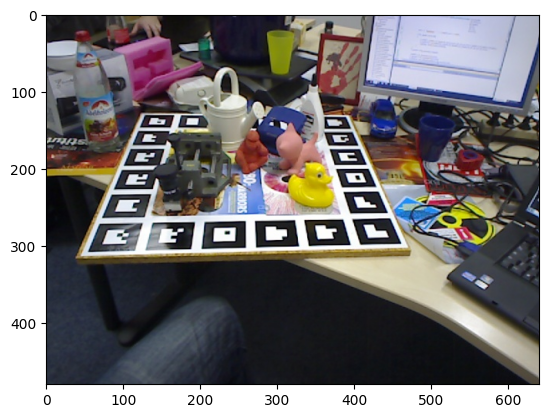

In [ ]:
img_path = "/content/datasets/linemod/DenseFusion/Linemod_preprocessed/data/01/rgb/0000.png"
img = Image.open(img_path).convert("RGB")
plt.imshow(img)

🔍 Now, explore the dataset and try to answer this questions:

- What information is on gt.yml?
- Where are the bounding boxes? Do they need some transformation?
- Where is the information needed to describe the 6D pose of the objects?
- What is the camera intrinsics?
- Are the models of the objects available in the dataset?

Take as inspiration this questions and make an extensive analysis of the data available in the dataset.

In [ ]:
!cat "/content/datasets/linemod/DenseFusion/Linemod_preprocessed/data/01/gt.yml"

0:
- cam_R_m2c: [0.09630630, 0.99404401, 0.05100790, 0.57332098, -0.01350810, -0.81922001, -0.81365103, 0.10814000, -0.57120699]
  cam_t_m2c: [-105.35775150, -117.52119142, 1014.87701320]
  obj_bb: [244, 150, 44, 58]
  obj_id: 1
1:
- cam_R_m2c: [0.11330900, 0.99136102, 0.06606490, 0.58543199, -0.01289290, -0.81061900, -0.80276400, 0.13052700, -0.58183599]
  cam_t_m2c: [-123.75479622, -117.18555277, 1020.10820079]
  obj_bb: [234, 151, 44, 58]
  obj_id: 1
2:
- cam_R_m2c: [0.14123000, 0.98992503, -0.01015710, 0.58996803, -0.09239960, -0.80212200, -0.79497898, 0.10729200, -0.59707397]
  cam_t_m2c: [-115.48054259, -19.45845384, 1060.18594215]
  obj_bb: [243, 208, 41, 55]
  obj_id: 1
3:
- cam_R_m2c: [0.12290500, 0.99189001, 0.03239260, 0.58224899, -0.04563730, -0.81172901, -0.80366701, 0.11862600, -0.58313602]
  cam_t_m2c: [-109.77283244, -21.69397943, 1049.28910138]
  obj_bb: [245, 207, 42, 55]
  obj_id: 1
4:
- cam_R_m2c: [0.10897600, 0.99175203, 0.06747660, 0.66973603, -0.02309180, -0.7422

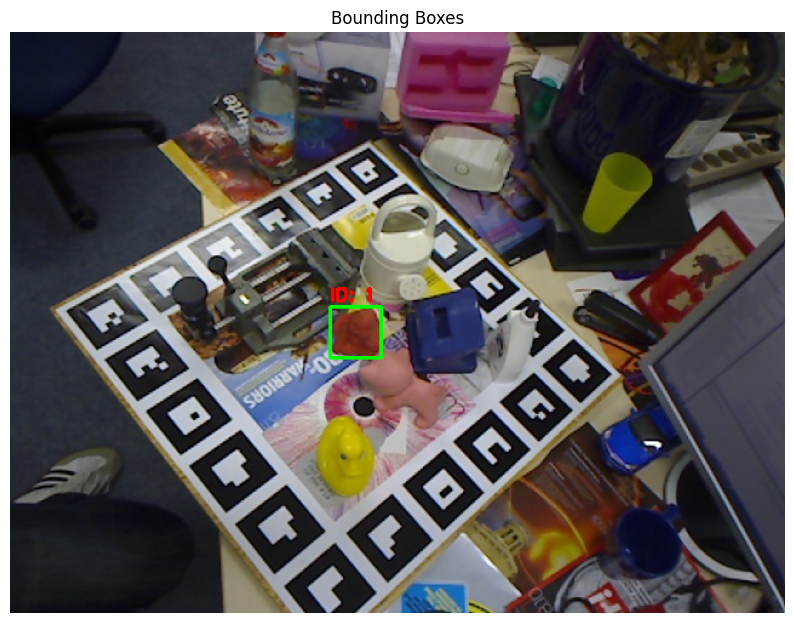

1
02


In [ ]:
# provo ad aggiungere bounding boxes


import cv2
import numpy as np
import matplotlib.pyplot as plt
import yaml

id_data = "01"
image_id = "0098"

# --- Inserisci il path all'immagine ---
image_path = f"/content/datasets/linemod/DenseFusion/Linemod_preprocessed/data/{id_data}/rgb/{image_id}.png"

# Carica l'immagine (in BGR)
image = cv2.imread(image_path)

# Controlla che l'immagine sia stata caricata
if image is None:
    raise FileNotFoundError(f"Immagine non trovata: {image_path}")

# Converti da BGR a RGB per visualizzare correttamente con matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Lista delle bounding box e degli ID
with open(f"/content/datasets/linemod/DenseFusion/Linemod_preprocessed/data/{id_data}/gt.yml", 'r') as stream:
    data_loaded = yaml.safe_load(stream)

objects = data_loaded[int(image_id) ]

# Disegna le bounding box
for obj in objects:
    x, y, w, h = obj["obj_bb"]
    obj_id = obj["obj_id"]

    # Rettangolo
    cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Testo con ID
    cv2.putText(image_rgb, f"ID: {obj_id}", (x, y - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)


# Mostra l'immagine con matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(image_rgb)
plt.axis("off")
plt.title("Bounding Boxes")
plt.show()
print(len(objects))
print(id)

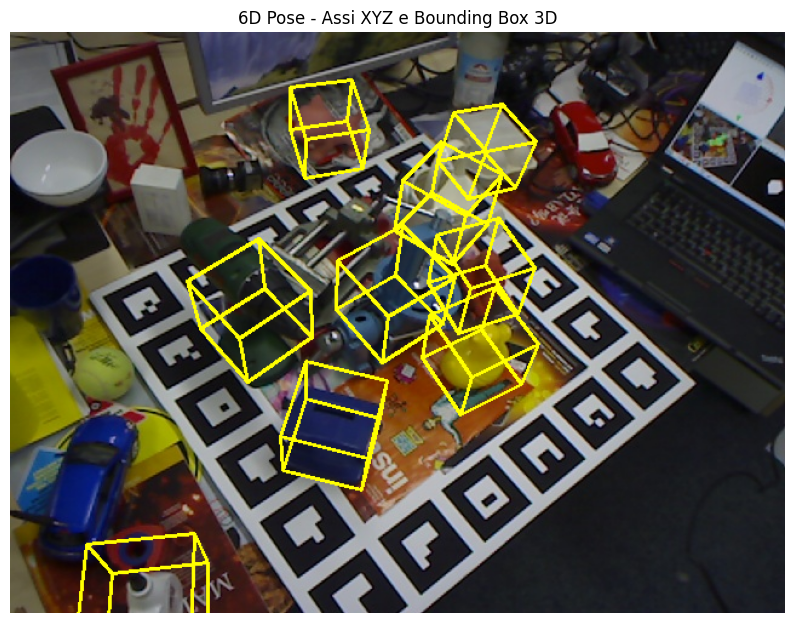

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import yaml

# Parametri
id_data = "02"
image_id = "0450"
image_index = int(image_id)

# Percorsi
base_path = f"/content/datasets/linemod/DenseFusion/Linemod_preprocessed/data/{id_data}"
image_path = f"{base_path}/rgb/{image_id}.png"
gt_path = f"{base_path}/gt.yml"
cam_path = f"{base_path}/info.yml"

# Carica immagine
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Immagine non trovata: {image_path}")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Carica pose
with open(f"/content/datasets/linemod/DenseFusion/Linemod_preprocessed/data/{id_data}/gt.yml", 'r') as stream:
    gt_data = yaml.safe_load(stream)
objects = gt_data[image_index]

# Carica intrinseche della fotocamera
with open(cam_path, 'r') as f:
    cam_data = yaml.safe_load(f)[image_index]

K = np.array(cam_data['cam_K']).reshape(3, 3)  # Matrice intrinseca della camera

# Funzione per disegnare assi XYZ (pose)
def draw_axes(image, R, t, K, length=50):
    axis_3D = np.float32([[0,0,0], [length,0,0], [0,length,0], [0,0,length]])  # origin, x, y, z
    rvec, _ = cv2.Rodrigues(R)
    tvec = t.reshape(3, 1)

    axis_2D, _ = cv2.projectPoints(axis_3D, rvec, tvec, K, None)
    axis_2D = axis_2D.reshape(-1, 2).astype(int)

    origin = tuple(axis_2D[0])
    image = cv2.line(image, origin, tuple(axis_2D[1]), (0,0,255), 2)  # X - Red
    image = cv2.line(image, origin, tuple(axis_2D[2]), (0,255,0), 2)  # Y - Green
    image = cv2.line(image, origin, tuple(axis_2D[3]), (255,0,0), 2)  # Z - Blue
    return image

# Funzione per disegnare la bounding box 3D
def draw_bbox(image, R, t, K, bbox_3D):
    rvec, _ = cv2.Rodrigues(R)
    tvec = t.reshape(3, 1)
    proj, _ = cv2.projectPoints(bbox_3D, rvec, tvec, K, None)
    proj = proj.reshape(-1, 2).astype(int)

    # Collegamenti tra vertici per formare la scatola (12 edges)
    connections = [
        (0,1), (1,2), (2,3), (3,0),  # base
        (4,5), (5,6), (6,7), (7,4),  # top
        (0,4), (1,5), (2,6), (3,7)   # vertical
    ]

    for i,j in connections:
        image = cv2.line(image, tuple(proj[i]), tuple(proj[j]), color=(255, 255, 0), thickness=2)
    return image

# Funzione per ottenere una bounding box 3D unitaria centrata nell'origine
def get_unit_bbox(size=50):
    # Bounding box centrata nell'origine, lato = size (in mm)
    half = size / 2
    return np.float32([
        [-half,-half,-half], [half,-half,-half],
        [half, half,-half], [-half, half,-half],
        [-half,-half, half], [half,-half, half],
        [half, half, half], [-half, half, half]
    ])

# Disegna le pose e le scatole per tutti gli oggetti
bbox_3D = get_unit_bbox(size=100)  # Modifica la dimensione se necessario

for obj in objects:
    R = np.array(obj["cam_R_m2c"]).reshape(3, 3)
    t = np.array(obj["cam_t_m2c"])
    image_rgb = draw_bbox(image_rgb, R, t, K, bbox_3D)

# Visualizza il risultato
plt.figure(figsize=(10, 8))
plt.imshow(image_rgb)
plt.axis("off")
plt.title("6D Pose - Assi XYZ e Bounding Box 3D")
plt.show()


# INVESTIGATION


```
- cam_R_m2c: [0.09630630, 0.99404401, 0.05100790, 0.57332098, -0.01350810, -0.81922001, -0.81365103, 0.10814000, -0.57120699]
  cam_t_m2c: [-105.35775150, -117.52119142, 1014.87701320]
  obj_bb: [244, 150, 44, 58]
  obj_id: 1
```
## Cam_R_m2c
(Camera Rotation - Model to Camera)

È una matrice di rotazione 3x3 (scritta in formato riga) che trasforma le coordinate dell’oggetto (model) nel sistema di coordinate della fotocamera (camera).
## cam_t_m2c
(Camera Translation - Model to Camera)

È un vettore di traslazione [x, y, z], in millimetri, che rappresenta la posizione dell’oggetto rispetto alla fotocamera.

## Obj_bb
(Object Bounding Box)
È il rettangolo di delimitazione 2D dell’oggetto nell’immagine, nel formato [x, y, width, height].

#**2.DATASET AND DATALOADER**

🔨 Now you need to build your own CustomDataset, make sure to include all the valuable information that you need to train your model. Use the knowledge that you gain in the previous step to build this class.

**NOTE:** Remember to check always the official documentation to give the correct format to your data.

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataset_root, split='train', train_ratio=0.8, seed=42):

        self.dataset_root = dataset_root
        self.split = split
        self.train_ratio = train_ratio
        self.seed = seed

        # Define image transformations
        self.transform = transforms.Compose([
            transforms.ToTensor(),
        ])

    #Define here some usefull functions to access the data
    def load_image(self, img_path):
        """Load an RGB image and convert to tensor."""
        img = Image.open(img_path).convert("RGB")
        return self.transform(img)

    def __len__(self):
        #Return the total number of samples in the selected split.
        return len(self.samples)

    def __getitem__(self, idx):
        #Load a dataset sample.
        folder_id, sample_id = self.samples[idx]
        img_path = os.path.join(self.dataset_root, 'data', f"{folder_id:02d}", f"rgb/{sample_id:04d}.png")
        img = self.load_image(img_path)

        #Dictionary with all the data
        return {
            "rgb": img,
            #...
            #...
            #...

        }


In [ ]:
train_dataset = CustomDataset(...)
train_loader = DataLoader(...)

print(f"Training samples: {len(train_dataset)}")
print(f"Training samples: {len(train_loader)}")

☝ Don't forget to visualize your data after these steps to check if the format

*   List item
*   List item

and the data make sense until this point.